# MIX number calculation

The MIX numner evauates stratification based on the temperature profile in the storage and the energy content of the storage and it is determined using the moment of energy $(M_{E})$. This number is defined as the difference in moment of energy between a perfectly stratified storage and an actual storage, to the difference in moment of energy between a perfeclty stratified storage and a fully mixed one. It is expressed by the following euqation:

$$MIX = \frac{M_{E}^{stratified} - M_{E}^{actual}}{M_{E}^{stratified} - M_{E}^{fully-mixed}} \tag{1}$$

MIX number is a dimensionless number, where $0$ represents a perfeclty stratified tank, while $1$ indicates a fully-mixed tank. For the calculations, the sotrage is divided in to layers based on the number of temperature measurements.The moment of energy $(M_{E})$, is calculated by suming up all the storage layers, using the following formula:

$$M_{E} = \sum_{n=1}^{N} \rho_{i} \cdot V_{i} \cdot C_{p,i} \cdot (T_{i} - T_{ref}) \cdot z_{i} \tag{2}$$

Where $n$ is a storage layer and $N$ is the total number of layers in the storage. For each layer, $\rho_{i}$ is the density of water, $V_{i}$ is the volume of water, $T_{i}$ is the water temperatrue, $C_{p,i}$ is the specific heat of water and $z_{i}$ is the distance from the center of the layer to the bottom of the storage.

**Mention also the stratified and fully mixed ideal cases!**

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [16]:
# %% Notes
# Alaternatively have a number of nodes in the top and bottom to fully mix to
# to simulate the imperfect diffusers. Then have smaller amount of mnodes to
# mix in the storage, e.g., simulate real water conduction
# Another note

# Ended up using rolling mean to simulate mixing

# To ensure no energy losses, mixing nodes has to be divisble by N?

# To do
# Calculate energy in or out?
# Heat losses


# Mix number is garbage because you need to set arbitrary T_ref, which actually
# has a big impact. For storages with solar thermal and hp (aka. two cold levels)
# this cannot work.
# Second problem with MIX number is that it is affected by the energy content...
# at high or low energy content, has problems.. does not perform well when close to being full or empty
# Mix number is instantenous - i.e., does not give info of period

# Hypothesis - as water get's cleaned out - stratification should increase?

In [27]:
# General
N = 5000 # Number of nodes in the storage
charge_time = 7*24  # Approximate
discharge_time = 7*24  # Approximate

# Water proprties
density_water = 980 # in kg/m3
specific_heat_water = 4200  # in J/(kg K)

# Time periods
simulation_period = 700 #8760  # number of hours
time_step = 1  # time step in hours
no_time_steps = int(simulation_period / time_step) # number of timesteps
times = np.arange(no_time_steps)*time_step  # array of time steps in hours

# Nodes used for mixing, charge and discharge
mixing_nodes = 1001  # uneven number! - gives the number of nodes that will be mixed (average temperature) at each timestep
# finds the half of the mixing nodes. These nodes are set to NaN by the rolling window,
# so is used for replacing the NaNs with actual temperature values
mixing_half_nodes = int(((mixing_nodes-1)/2))
charge_nodes = np.max([int(np.round(N/(charge_time/time_step))), 1]) # number of nodes charged each time step (avoid numerical diffusion)
discharge_nodes = np.max([int(np.round(N/(discharge_time/time_step))), 1]) # number of nodes discharged each time step (to avoid numerical diffusion)

# Temperatures
T_hot = 90 # charge temperature
T_cold = 45 # discharge temperature
T_threshold = 10 # sets a threshold for the maximum/minimum temperature that can be during charge/discharge at the top and bottom of the tank

# Initialize the storage as empty
T_start = T_cold
temp = pd.Series(np.ones(N)*T_start)
temp_mix = temp

In [28]:
# Set the case that will be simulated, e.g. "fully_mixed", "fully_stratified".
# Otherwise, it simulates storage operation with mixing based on mixing_nodes.
case = ''#'fully_stratified'
plot = False
dfl = []

charging = 1  # Initialize storage as charging
for ii, t in enumerate(times):
    # Check if charging or discharging
    if (temp.iloc[-1] >= T_hot - T_threshold) & (charging == 1):
        charging = 0  # discharging
    elif (temp.iloc[0] <= T_cold + T_threshold) & (charging == 0):
        charging = 1  # charging

    # Charge or discharge, i.e., add hot water to the top or cold water to the bottom
    shift = charge_nodes*charging - discharge_nodes*(1-charging)
    temp = temp.shift(shift).fillna(T_hot*charging + T_cold*(1-charging))

    # Mixing - use pandas rolling (min_periods=1 avoids NaN at ends)
    # Results in very small difference in avg. temperature
    if case == 'fully_mixed':
        temp_mix[:] = np.mean(temp)
    elif case == 'fully_stratified':
        temp_mix = temp
    else:
        temp_mix = temp.rolling(mixing_nodes, win_type='boxcar', center=True, min_periods=mixing_nodes).mean()
        if charging:
            temp_mix[:mixing_half_nodes] = np.mean(temp[:mixing_half_nodes])
            temp_mix[-mixing_half_nodes:] = temp[-mixing_half_nodes:]
        else:
            temp_mix[-mixing_half_nodes:] = np.mean(temp[-mixing_half_nodes:])
            temp_mix[:mixing_half_nodes] = temp[:mixing_half_nodes]

    temp = temp_mix
    dfl.append(temp)

    # Plot
    if plot:
        if np.mod(ii, 25) == 0:
            plt.plot(temp[::-1], np.linspace(0,1,len(temp)))
            plt.xlim(40,100)
            plt.ylim(0,1)
            plt.show()

In [29]:
# Create dataframe containing the temperature profiles for each time step.
# Rows are the simulation time steps and columns are the layers of the storage starting from the top (0) to the bottom (N).
df = pd.concat(dfl, axis=1).T

First the energy content of the investigated storage is calculated. In order to perform this operation, a reference temperature has to be selected ($T_{ref}$). This temperature should be equal to the lowest temperature reached in the storage. 

In [30]:
volume_per_layer = 1/N # assuming that the storage is a cube 1x1x1 m

T_ref = T_cold # reference temperature for calculating energy

Q_storage = (density_water * volume_per_layer * specific_heat_water * (df - T_ref)).sum(axis='columns') # energy content of storage

The moment of energy is calculated for a fully mixed storage. The temperature of the fully mixed storage is the average temperature of the actual storage for each timestep. The volume of the mixed storage ($V_{min}$) is essentially equal with the volume of the actual storage. The distance from the middle of the volume to the bottom of the storage is in this case, due to the simplified geoemtry, equal to half the height of the actual storage.

In [31]:
T_avg = df.mean(axis='columns') # temperature of mixed storage (average temperature)

V_mix = Q_storage/(density_water * specific_heat_water * (T_avg - T_ref)) # volume of mixed storage using the energy content of the actual storage

dist_mix = V_mix/2 # distance from the bottom of the storage to the middle of the V_mix

M_mix = density_water * specific_heat_water * V_mix * T_avg * dist_mix # # moment of energy for fully mixed storage

The perfeclty stratified storage is defined as a strorage that has the same energy content with the actual storage but has always the highest possible temperature ($T_{hot}$) at the top. THe volume of the storage that is not used by this temprature is assumed to have the lowest possible temperature ($T_{cold}$) and thus no energy content.

In [32]:
V_hot = Q_storage/(density_water * specific_heat_water * (T_hot - T_ref)) # volume of hot water in the stratified storage using energy content of actual storage

dist_hot = 1 - V_hot/2 # distance from the bottom of the storage

M_strat = density_water * V_hot * specific_heat_water * T_hot * dist_hot # Moment of energy for stratified tank

Calculation of the moment of energy for the actual storage.

In [33]:
dist = np.arange(1/N/2, 1, 1/N)[::-1] # Make a list with the distances of each layer from the bottom of the storage

M_exp = density_water * volume_per_layer* dist * specific_heat_water * df # Moment of energy for the actual storage

Calculation of the MIX number for the storage using equation $(1)$.

In [34]:
MIX = (M_strat - M_exp.sum(axis=1)) / (M_strat - M_mix)

Plot of the MIX number along with the energy cintent of the storage.

(0.0, 1.0)

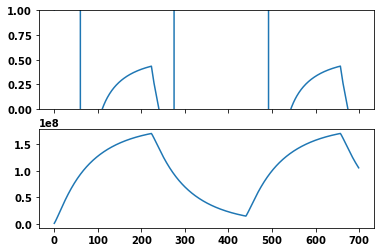

In [35]:
fig, axes = plt.subplots(nrows=2, sharex=True)
MIX.plot(ax=axes[0])
Q_storage.plot(ax=axes[1])
axes[0].set_ylim(0,1)
#axes[-1].set_xlim(0,430)

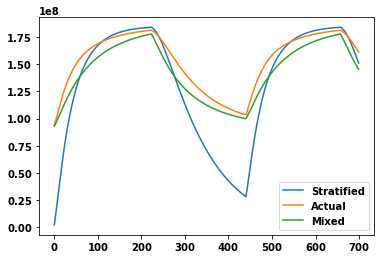

In [36]:
fig, ax = plt.subplots()
M_strat.plot(ax=ax, label='Stratified')
M_exp.sum(axis=1).plot(ax=ax, label='Actual')
M_mix.plot(ax=ax, label='Mixed')

ax.legend()